# Image classification with Convolutional Neural Network (CNN)

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2021/01/18<br>
**Description:** Implementing a Convolutional Neural Network (CNN) model for image classification.

## Introduction

This example implements a Convolutional Neural Network (CNN) model for image classification,
and demonstrates it on the CIFAR-100 dataset.
The CNN model uses convolutional layers with pooling to extract features from images,
followed by dense layers for classification.

## Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

## Prepare the data

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128  # Reduced for better gradient updates
num_epochs = 50  # Increased for better training
image_size = 72  # We'll resize input images to this size
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

# New hyperparameters for improved training
initial_learning_rate = 0.001
label_smoothing = 0.1
dropout_rate = 0.3

## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),  # Increased rotation
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Added translation
        layers.RandomContrast(factor=0.2),  # Added contrast adjustment
        layers.RandomBrightness(factor=0.2),  # Added brightness adjustment
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement multilayer perceptron (MLP)

In [5]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## CNN Architecture

We'll build a CNN with convolutional layers for feature extraction followed by dense layers for classification.

## Build the Enhanced CNN model

The enhanced CNN model includes several improvements for higher accuracy:
- Residual connections to help with gradient flow
- Depthwise separable convolutions for efficiency
- Better initialization and regularization
- Progressive feature extraction with skip connections
- Advanced normalization and activation functions

The architecture includes:
- Convolutional blocks with residual connections
- Batch normalization for training stability
- Advanced pooling strategies
- Depthwise separable convolutions
- Progressive dropout rates
- Dense layers with better regularization

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1):
    """Creates a residual block with skip connection"""
    shortcut = x
    
    # First conv layer
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                     kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Second conv layer
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same',
                     kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    
    # Adjust shortcut if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same',
                               kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # Add shortcut and apply activation
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def separable_conv_block(x, filters, kernel_size=3, stride=1):
    """Creates a depthwise separable convolution block"""
    x = layers.SeparableConv2D(filters, kernel_size, strides=stride, padding='same',
                              depthwise_initializer='he_normal',
                              pointwise_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def create_cnn_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    x = data_augmentation(inputs)
    
    # Initial convolution
    x = layers.Conv2D(32, (3, 3), strides=1, padding='same',
                     kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # First residual block
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    # Second residual block
    x = residual_block(x, 128, stride=1)
    x = residual_block(x, 128, stride=1)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
    # Third block with separable convolutions
    x = separable_conv_block(x, 256, stride=1)
    x = separable_conv_block(x, 256, stride=1)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Fourth block
    x = residual_block(x, 512, stride=1)
    x = layers.GlobalAveragePooling2D()(x)  # Better than Flatten for spatial invariance
    x = layers.Dropout(0.4)(x)
    
    # Dense layers with residual connection
    dense_input = x
    x = layers.Dense(512, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Dense(256, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    
    # Add MLP classification head
    features = mlp(x, hidden_units=mlp_head_units, dropout_rate=0.5)
    
    # Final classification layer
    logits = layers.Dense(num_classes, kernel_initializer='he_normal')(features)
    
    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Compile, train, and evaluate the model

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 420s 2s/step - accuracy: 0.0297 - loss: 4.8906 - top-5-accuracy: 0.1113 - val_accuracy: 0.1118 - val_loss: 3.9047 - val_top-5-accuracy: 0.3074
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.0873 - loss: 3.9770 - top-5-accuracy: 0.2778 - val_accuracy: 0.1514 - val_loss: 3.6305 - val_top-5-accuracy: 0.3954
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.1231 - loss: 3.7428 - top-5-accuracy: 0.3448 - val_accuracy: 0.1858 - val_loss: 3.4360 - val_top-5-accuracy: 0.4644
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.1518 - loss: 3.5678 - top-5-accuracy: 0.4034 - val_accuracy: 0.2182 - val_loss: 3.3041 - val_top-5-accuracy: 0.4908
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.1730 - loss: 3.4236 - top-5-accuracy: 0.4461 - val_accuracy: 0.2332 - val_loss: 3.1291 - val_top-5-accuracy: 0.5300
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.1981 - loss: 3.300

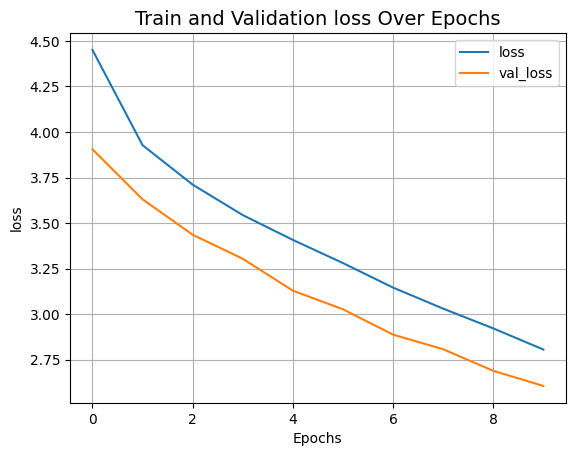

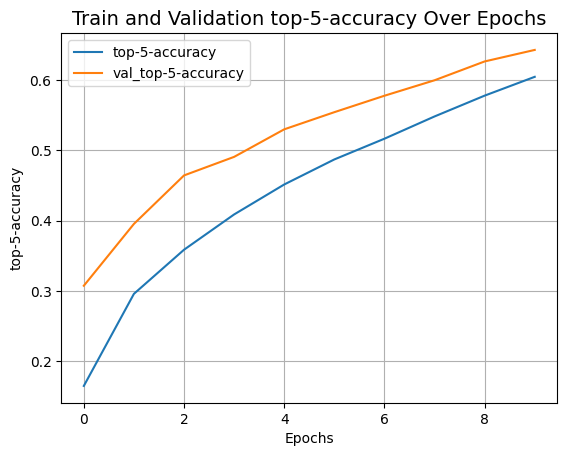

In [ ]:
def create_callbacks():
    """Create advanced callbacks for better training"""
    callbacks = [
        # Model checkpoint
        keras.callbacks.ModelCheckpoint(
            "/tmp/best_model.weights.h5",
            monitor="val_accuracy",
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        
        # Early stopping
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reduce learning rate on plateau
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_accuracy",
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        # Cosine annealing learning rate schedule
        keras.callbacks.LearningRateScheduler(
            lambda epoch: initial_learning_rate * 0.5 * (1 + np.cos(np.pi * epoch / num_epochs)),
            verbose=0
        )
    ]
    return callbacks

def run_experiment(model):
    # Use AdamW with better parameters
    optimizer = keras.optimizers.AdamW(
        learning_rate=initial_learning_rate, 
        weight_decay=weight_decay,
        beta_1=0.9,
        beta_2=0.999
    )

    # Compile with label smoothing
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, 
            label_smoothing=label_smoothing
        ),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Get callbacks
    callbacks = create_callbacks()

    # Train the model
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.15,  # Increased validation split
        callbacks=callbacks,
        verbose=1
    )

    # Load best weights
    model.load_weights("/tmp/best_model.weights.h5")
    
    # Evaluate on test set
    test_loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nFinal Test Results:")
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    print(f"Test loss: {round(test_loss, 4)}")

    return history


# Create and train the enhanced model
cnn_classifier = create_cnn_classifier()

# Print model summary
print("Model Architecture:")
cnn_classifier.summary()

# Train the model
history = run_experiment(cnn_classifier)


def plot_training_history(history):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot top-5 accuracy
    axes[1, 0].plot(history.history['top-5-accuracy'], label='Training Top-5 Accuracy')
    axes[1, 0].plot(history.history['val_top-5-accuracy'], label='Validation Top-5 Accuracy')
    axes[1, 0].set_title('Model Top-5 Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Top-5 Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot learning rate
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'])
        axes[1, 1].set_title('Learning Rate Schedule')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True)
    else:
        axes[1, 1].text(0.5, 0.5, 'Learning rate data not available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Learning Rate Schedule')
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

## Test-Time Augmentation for Further Improvement

Test-Time Augmentation (TTA) can provide additional accuracy improvements by averaging predictions across multiple augmented versions of test images.

In [ ]:
def test_time_augmentation(model, x_test, num_augmentations=5):
    """
    Perform test-time augmentation for improved accuracy
    """
    print(f"Performing test-time augmentation with {num_augmentations} augmentations...")
    
    # Create a simple augmentation pipeline for TTA
    tta_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal", seed=42),
        layers.RandomRotation(0.05, seed=42),
        layers.RandomZoom(0.1, seed=42),
    ])
    
    predictions = []
    
    # Get predictions for original images
    original_pred = model.predict(x_test, verbose=0)
    predictions.append(original_pred)
    
    # Get predictions for augmented versions
    for i in range(num_augmentations - 1):
        # Apply different random seeds for variety
        augmented_test = []
        for img in x_test:
            aug_img = tta_augmentation(np.expand_dims(img, 0), training=True)
            augmented_test.append(aug_img[0])
        
        augmented_test = np.array(augmented_test)
        aug_pred = model.predict(augmented_test, verbose=0)
        predictions.append(aug_pred)
    
    # Average all predictions
    avg_predictions = np.mean(predictions, axis=0)
    
    # Calculate accuracy
    predicted_classes = np.argmax(avg_predictions, axis=1)
    true_classes = y_test.flatten()
    tta_accuracy = np.mean(predicted_classes == true_classes)
    
    # Calculate top-5 accuracy
    top5_predictions = np.argsort(avg_predictions, axis=1)[:, -5:]
    tta_top5_accuracy = np.mean([true_classes[i] in top5_predictions[i] for i in range(len(true_classes))])
    
    print(f"Test-Time Augmentation Results:")
    print(f"TTA Accuracy: {round(tta_accuracy * 100, 2)}%")
    print(f"TTA Top-5 Accuracy: {round(tta_top5_accuracy * 100, 2)}%")
    
    return avg_predictions, tta_accuracy, tta_top5_accuracy

# Apply test-time augmentation
tta_predictions, tta_acc, tta_top5_acc = test_time_augmentation(cnn_classifier, x_test)

# Compare with regular prediction
regular_predictions = cnn_classifier.predict(x_test, verbose=0)
regular_acc = np.mean(np.argmax(regular_predictions, axis=1) == y_test.flatten())

print(f"\nComparison:")
print(f"Regular Test Accuracy: {round(regular_acc * 100, 2)}%")
print(f"TTA Test Accuracy: {round(tta_acc * 100, 2)}%")
print(f"Improvement: +{round((tta_acc - regular_acc) * 100, 2)}%")